In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
train=pd.read_csv(r'Data_Sets\train.csv')
test=pd.read_csv(r'Data_Sets\test.csv')

In [3]:
train.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


In [4]:
test.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1
3,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2
4,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3


In [5]:
# Adding a column to know which row belong to which dataset
train['source']='train'
test['source']='test'



In [6]:
train.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,source
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,train
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375,train
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268,train
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376,train
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829,train


In [7]:
test.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,source
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3,test
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3,test
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1,test
3,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2,test
4,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3,test


In [8]:
target=train['Sales']

In [9]:
train.drop(['Sales'],axis=1,inplace=True)

In [10]:
train.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,source
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,train
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,train
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,train
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,train
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,train


In [11]:
combined=pd.concat([train,test],ignore_index=True)

In [12]:
combined.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,source
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,train
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,train
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,train
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,train
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,train


In [13]:
combined.isna().sum()

Item_ID                 0
Item_W                  0
Item_Type               0
Item_MRP                0
Outlet_ID               0
Outlet_Year             0
Outlet_Size             0
Outlet_Location_Type    0
source                  0
dtype: int64

In [14]:
combined.duplicated().sum()

np.int64(0)

In [15]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125520 entries, 0 to 125519
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Item_ID               125520 non-null  object 
 1   Item_W                125520 non-null  float64
 2   Item_Type             125520 non-null  object 
 3   Item_MRP              125520 non-null  float64
 4   Outlet_ID             125520 non-null  object 
 5   Outlet_Year           125520 non-null  int64  
 6   Outlet_Size           125520 non-null  object 
 7   Outlet_Location_Type  125520 non-null  object 
 8   source                125520 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 8.6+ MB


In [16]:
train_cleaned = combined[combined['source'] == 'train'].copy()
test_cleaned = combined[combined['source'] == 'test'].copy()


In [17]:
train_cleaned['Sales']=target

In [18]:
print(train_cleaned.shape)
print(test_cleaned.shape)

print(train_cleaned.columns)
print(test_cleaned.columns)


(87864, 10)
(37656, 9)
Index(['Item_ID', 'Item_W', 'Item_Type', 'Item_MRP', 'Outlet_ID',
       'Outlet_Year', 'Outlet_Size', 'Outlet_Location_Type', 'source',
       'Sales'],
      dtype='object')
Index(['Item_ID', 'Item_W', 'Item_Type', 'Item_MRP', 'Outlet_ID',
       'Outlet_Year', 'Outlet_Size', 'Outlet_Location_Type', 'source'],
      dtype='object')


In [19]:
train_cleaned.drop(columns=['source'],inplace=True)
test_cleaned.drop(columns=['source'],inplace=True)

In [20]:
train_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


In [21]:
test_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
87864,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3
87865,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3
87866,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1
87867,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2
87868,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3


## EDA

##### Univariate Analysis

In [22]:
num_cols=train_cleaned.select_dtypes(include=['number','int','float'])
cat_cols=train_cleaned.select_dtypes(exclude=['number','int','float'])

In [23]:
num_cols.columns

Index(['Item_W', 'Item_MRP', 'Outlet_Year', 'Sales'], dtype='object')

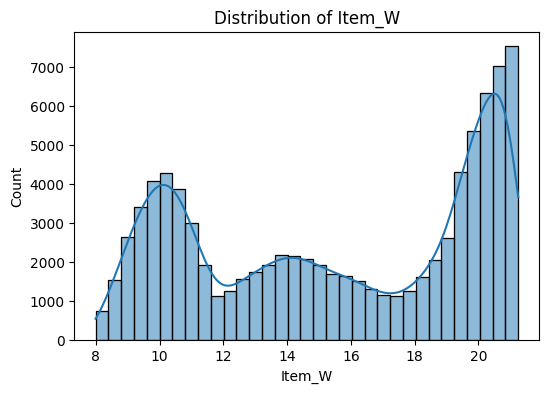

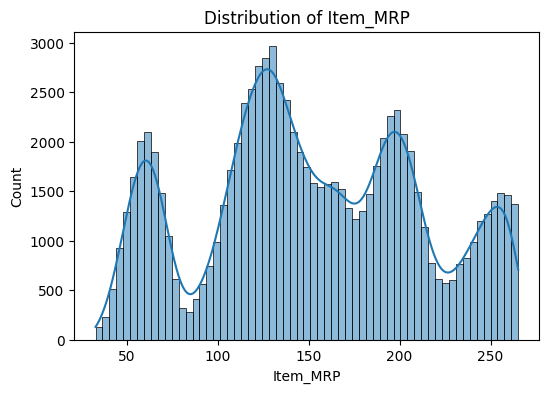

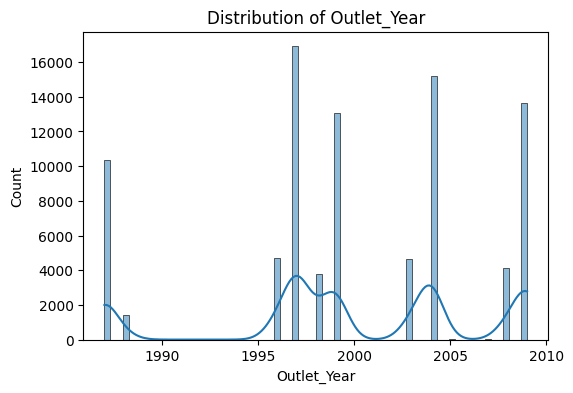

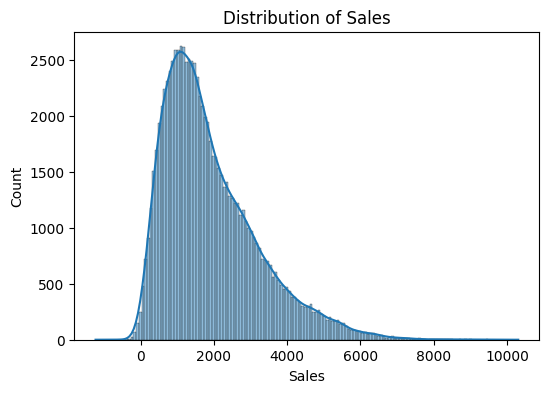

In [24]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(train_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [25]:
from scipy.stats import skew
print("Skewness:", skew(num_cols['Sales']))

Skewness: 1.125429741747798


In [26]:
num_cols['Sales'].describe()

count    87864.000000
mean      1911.842120
std       1291.386004
min      -1229.360345
25%        959.249675
50%       1606.307877
75%       2608.057736
max      10309.283310
Name: Sales, dtype: float64

In [27]:
# Skewness 1.125 means that the target column is right skewed, hence we use log transformation to make it normal

In [28]:
train_cleaned['Sales_transformed'] = np.log1p(num_cols['Sales'])

c:\Users\Lenovo\OneDrive\Desktop\Supermarket_Data_Analysis\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


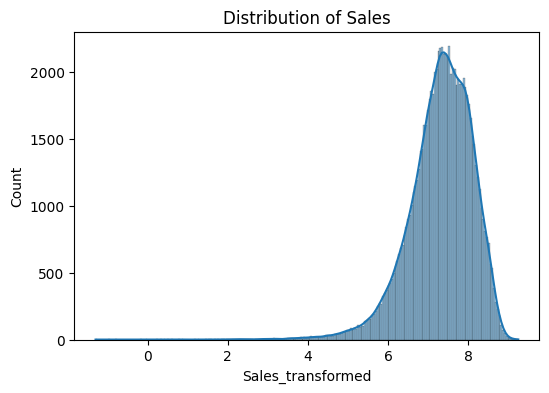

In [29]:
plt.figure(figsize=(6,4))
sns.histplot(train_cleaned['Sales_transformed'], kde=True)
plt.title(f'Distribution of {col}')
plt.show()

In [30]:
from scipy.stats import skew
print(skew(train_cleaned['Sales_transformed']))

nan


In [31]:
# num_cols['Sales_transformed'].describe()


In [32]:
# using powertransformer to handle skeweness

In [33]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
train_cleaned['Sales_transformed'] = pt.fit_transform(num_cols[['Sales']])


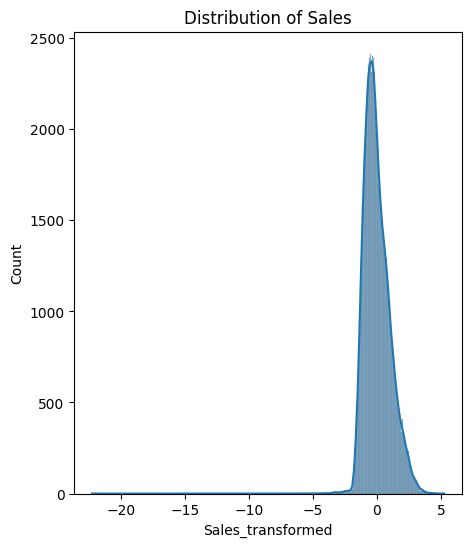

In [34]:
plt.figure(figsize=(5,6))
sns.histplot(train_cleaned['Sales_transformed'], kde=True)
plt.title(f'Distribution of {col}')
plt.show()

In [35]:
print(skew(train_cleaned['Sales_transformed']))

0.41042399947670877


In [36]:
num_cols=train_cleaned.select_dtypes(include=['int','float','number'])

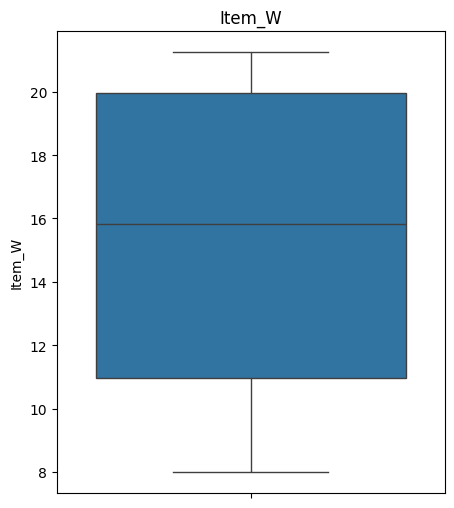

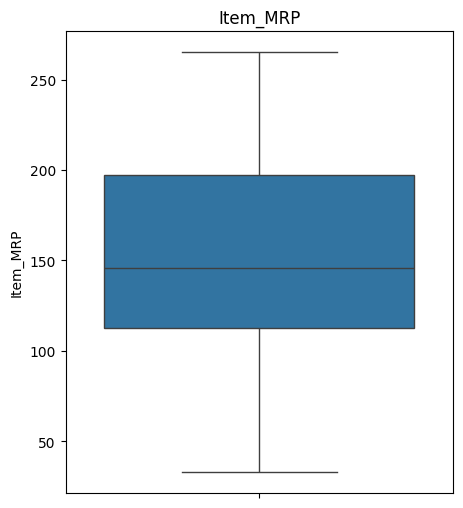

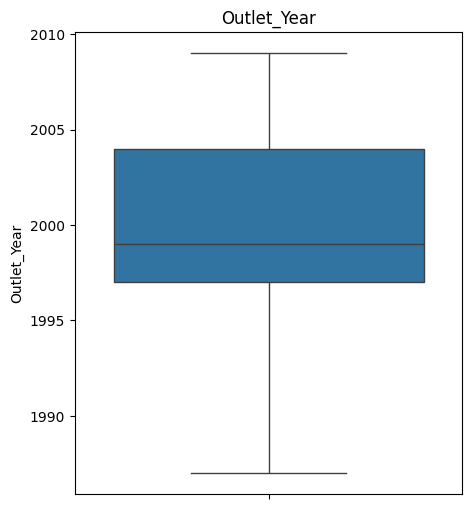

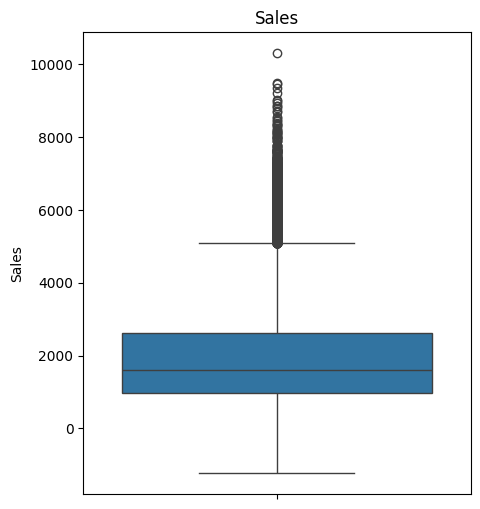

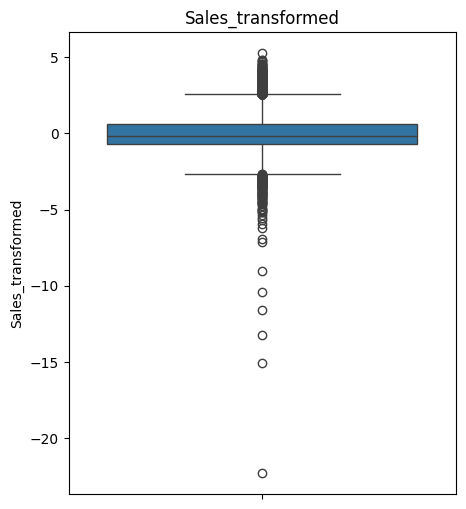

In [37]:
for col in num_cols:
    plt.figure(figsize=(5,6))
    sns.boxplot(num_cols[col])
    plt.title(col)
    plt.show()

In [38]:
# We can see that there are outliers present in the target column

In [39]:
import numpy as np

Q1 = num_cols['Sales_transformed'].quantile(0.25)
Q3 = num_cols['Sales_transformed'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = num_cols[(num_cols['Sales_transformed'] < lower_bound) | (num_cols['Sales_transformed'] > upper_bound)]
print(f"Outlier count: {len(outliers)} ({len(outliers)/len(num_cols)*100:.2f}% of data)")


Outlier count: 1377 (1.57% of data)


In [40]:
# To deal with outlier we use Winsorization

# Winsorization is a statistical technique used to limit the influence of extreme values (outliers)
#  by capping them at specific percentile thresholds — rather than removing them.
# It brings extreme values closer to the bulk of the data, instead of deleting them.


In [41]:
train_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,Sales_transformed
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,0.659990
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375,1.185292
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268,0.972822
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376,-0.413453
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829,-0.057946


In [42]:
from scipy.stats.mstats import winsorize
train_cleaned['Sales_transformed_capped']=winsorize(train_cleaned['Sales_transformed'],limits=[0.01,0.01])


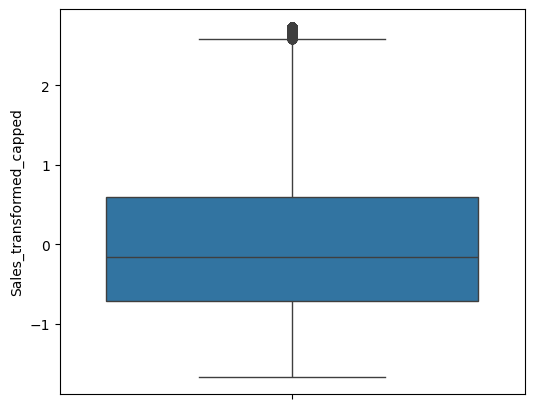

In [43]:
plt.figure(figsize=(6,5))
sns.boxplot(train_cleaned['Sales_transformed_capped'])
plt.show()

In [44]:
cat_cols.head()

,Item_ID,Item_Type,Outlet_ID,Outlet_Size,Outlet_Location_Type
0,FDU32,Baking Goods,OUT046,Small,Tier 2
1,NCT54,Meat,OUT035,Small,Tier 1
2,FDW08,Hard Drinks,OUT035,Small,Tier 3
3,FDJ22,Starchy Foods,OUT046,Small,Tier 1
4,FDF47,Baking Goods,OUT035,Small,Tier 3


In [45]:
for col in cat_cols:
    vc = train_cleaned[col].value_counts() # counts how many times each unique category appears in that column.
    pct = train_cleaned[col].value_counts(normalize=True).mul(100)#finds what percentage of total data each represents.
    summary = pd.concat([vc, pct], axis=1)
    summary.columns = ['count','percent']
    print(f"\n=== {col} ===")
    print(summary)



=== Item_ID ===
         count   percent
Item_ID                 
FDE11      419  0.476873
NCE07      362  0.412000
NCL18      346  0.393790
NCO06      336  0.382409
FDD51      329  0.374442
...        ...       ...
DRF60        2  0.002276
FDC32        2  0.002276
FDI12        2  0.002276
FDA22        1  0.001138
NCM19        1  0.001138

[895 rows x 2 columns]

=== Item_Type ===
                       count    percent
Item_Type                              
Baking Goods           14666  16.691705
Fruits and Vegetables  14328  16.307020
Meat                    8099   9.217655
Snack Foods             7817   8.896704
Household               6018   6.849222
Soft Drinks             5396   6.141309
Frozen Foods            5129   5.837431
Canned                  4565   5.195529
Dairy                   3807   4.332833
Others                  3688   4.197396
Breads                  3509   3.993672
Hard Drinks             3129   3.561185
Health and Hygiene      2995   3.408677
Starchy Foods  

-Bivariate Data

Regression Line


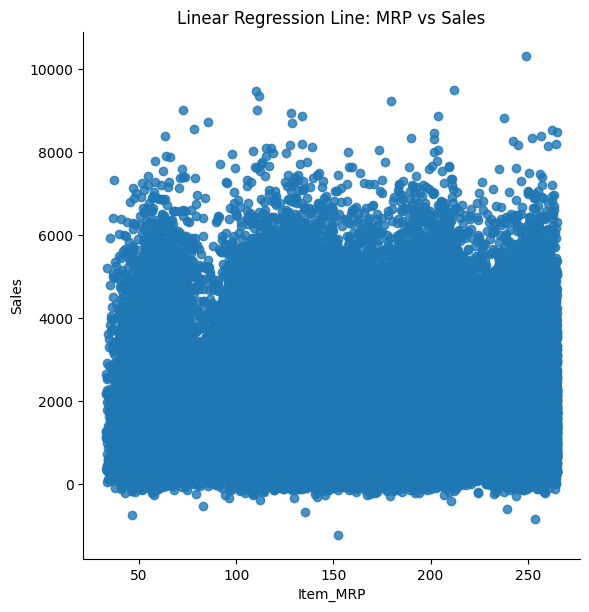

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume train_processed has been preprocessed
numeric_cols = train_cleaned.select_dtypes(include=['float64','int64']).columns

# Compute correlation matrix
corr_matrix = train_cleaned[numeric_cols].corr()

#Regression line plot
sns.lmplot(x='Item_MRP', y='Sales', data=train_cleaned, height=6)
plt.title("Linear Regression Line: MRP vs Sales")
plt.show()



Scatter Plot


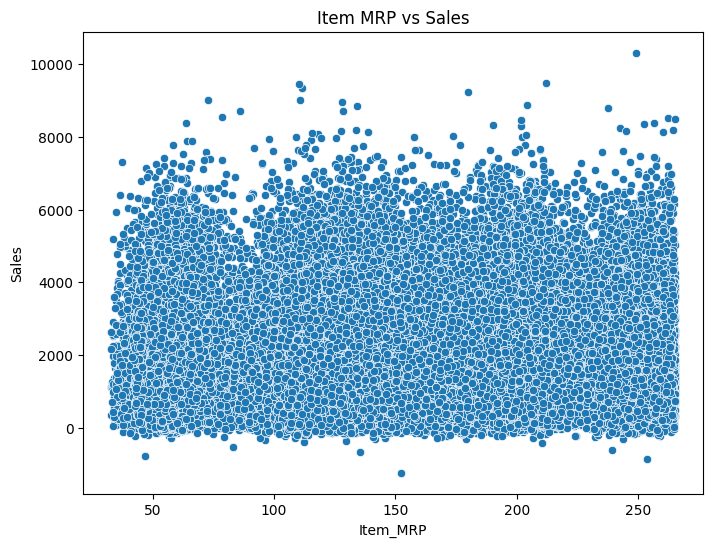

In [47]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Item_MRP', y='Sales', data=train_cleaned)
plt.title("Item MRP vs Sales")
plt.show()


Box plot


To see the sales in outlet location types


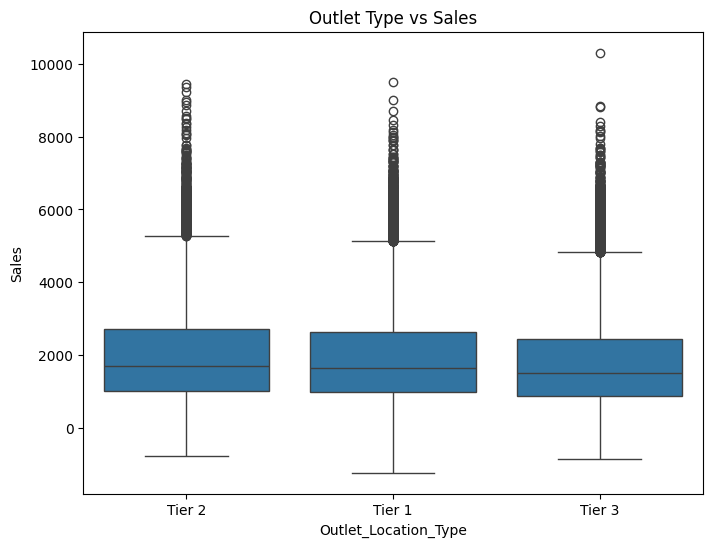

In [48]:
categorical_cols = train_cleaned.select_dtypes(include=['object']).columns

# Example: How Outlet_Location_Type affects Sales
plt.figure(figsize=(8,6))
sns.boxplot(x='Outlet_Location_Type', y='Sales', data=train_cleaned)
plt.title("Outlet Type vs Sales")
plt.show()

Feature enginering

In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# --------------------------------------
# 1️⃣ Load your data
# --------------------------------------
train = pd.read_csv(r'Data_Sets\train.csv')
test = pd.read_csv(r'Data_Sets\test.csv')

# Add a 'source' column so we can combine and process together
train['source'] = 'train'
test['source'] = 'test'

# Combine datasets for consistent processing
combined = pd.concat([train, test], ignore_index=True)

# --------------------------------------
# 2️⃣ Create new derived features
# --------------------------------------

# 🔹 (a) Outlet Age
# Convert outlet year into age (assuming current year = 2013)
combined['Outlet_Age'] = 2013 - combined['Outlet_Year']

# 🔹 (b) Item Category
# Extract first two letters from Item_ID to classify into Food/Drinks/Non-Consumable
combined['Item_Category'] = combined['Item_ID'].str[:2].map({
    'FD': 'Food',
    'DR': 'Drinks',
    'NC': 'Non-Consumable'
})

# 🔹 (c) Item MRP Band
# Bin continuous price into four categories (Low, Medium, High, Premium)
bins = [0, 100, 200, 300, 400]
labels = ['Low', 'Medium', 'High', 'Premium']
combined['Item_MRP_Band'] = pd.cut(combined['Item_MRP'], bins=bins, labels=labels)

# 🔹 (d) Ordinal Encoding for Outlet Size & Location
# Convert ordered categories into numeric scale
size_map = {'Small': 1, 'Medium': 2, 'High': 3}
loc_map = {'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3}
combined['Outlet_Size_Num'] = combined['Outlet_Size'].map(size_map)
combined['Outlet_Location_Num'] = combined['Outlet_Location_Type'].map(loc_map)

# 🔹 (e) Interaction Feature
# Relationship between item price and weight
combined['MRP_Weight'] = combined['Item_MRP'] * combined['Item_W']

# --------------------------------------
# 3️⃣ Handle missing values
# --------------------------------------
# Replace missing weights with median
combined['Item_W'].fillna(combined['Item_W'].median(), inplace=True)

# --------------------------------------
# 4️⃣ Encoding categorical features
# --------------------------------------

# 🔹 (a) Label Encoding
# Convert text categories into numeric labels
label_cols = ['Item_Type', 'Item_Category', 'Outlet_ID', 'Item_MRP_Band']
le = LabelEncoder()
for col in label_cols:
    combined[col] = le.fit_transform(combined[col])

# 🔹 (b) One-Hot Encoding (optional alternative)
# Uncomment the next line if you prefer one-hot encoding instead of label encoding
# combined = pd.get_dummies(combined, columns=['Item_Type', 'Item_Category', 'Outlet_ID', 'Item_MRP_Band', 'Outlet_Size', 'Outlet_Location_Type'], drop_first=True)

# --------------------------------------
# 5️⃣ Split back into train/test datasets
# --------------------------------------
train_cleaned = combined[combined['source'] == 'train'].copy()
test_cleaned = combined[combined['source'] == 'test'].copy()

# Drop the source column as it’s no longer needed
train_cleaned.drop(['source'], axis=1, inplace=True)
test_cleaned.drop(['source'], axis=1, inplace=True)

# --------------------------------------
# ✅ Final check
# --------------------------------------
print("Train cleaned shape:", train_cleaned.shape)
print("Test cleaned shape:", test_cleaned.shape)
print("\nPreview of final engineered features:")
print(train_cleaned.head())
